In [21]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [22]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[0][:23]==img1_tuple[0][:23]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[0][:23]!=img0_tuple[0][:23])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [35]:
class Config():
    training_dir = "C:\\dss\\"
    train_batch_size = 64
    train_number_epochs = 10

In [24]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [25]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


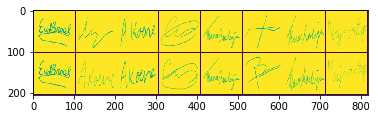

In [29]:
#0-similar sign 1-non similar
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
plt.imshow(torchvision.utils.make_grid(concatenated).numpy()[0,:,:])
print(example_batch[2].numpy())

In [30]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),  #398*398*4
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3), #396*396*8
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3), #8*394*394
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [31]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [32]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

In [38]:
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.00001 )

In [34]:
counter = []
loss_history = [] 
iteration_number= 0

In [39]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0 ,img1 , label
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

Epoch number 0
 Current loss 1.4658665657043457

Epoch number 0
 Current loss 1.4479490518569946

Epoch number 0
 Current loss 1.4643305540084839

Epoch number 1
 Current loss 1.2328561544418335

Epoch number 1
 Current loss 1.2044018507003784

Epoch number 1
 Current loss 1.1653425693511963

Epoch number 2
 Current loss 1.1187667846679688

Epoch number 2
 Current loss 1.1590379476547241

Epoch number 2
 Current loss 1.086471438407898

Epoch number 3
 Current loss 1.2103121280670166

Epoch number 3
 Current loss 1.2168824672698975

Epoch number 3
 Current loss 1.1610469818115234

Epoch number 4
 Current loss 1.152435541152954

Epoch number 4
 Current loss 1.1850124597549438

Epoch number 4
 Current loss 1.1865509748458862

Epoch number 5
 Current loss 1.2037243843078613

Epoch number 5
 Current loss 1.1598538160324097

Epoch number 5
 Current loss 1.1319829225540161

Epoch number 6
 Current loss 1.1518770456314087

Epoch number 6
 Current loss 1.1193976402282715

Epoch number 6
 Curren

tensor([0.7810], grad_fn=<NormBackward1>)
similar


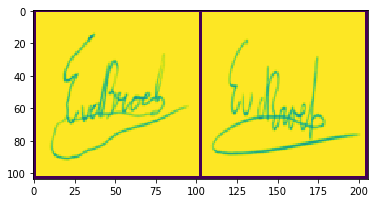

In [71]:
folder_dataset_test = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)
#for i in range(10):
_,x1,label2 = next(dataiter)
concatenated = torch.cat((x0,x1),0)

plt.imshow(torchvision.utils.make_grid(concatenated).numpy()[0,:,:])
    
output1,output2 = net(Variable(x0),Variable(x1))
euclidean_distance = F.pairwise_distance(output1, output2)
print(euclidean_distance)
if euclidean_distance<0.8:
    print("similar")
else:
    print("dissimilar")
    #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))